<a href="https://colab.research.google.com/github/stanislavlia/machinelearning_algorithms/blob/main/DCGAN_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import os

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
#load MNIST

(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

#Normalizing the images to be between [-1, 1]

train_images = (train_images - 127.5) / 127.5

In [39]:
np.min(train_images), np.max(train_images)

(-1.0, 1.0)

![image.png](attachment:image.png)

## The generator model

In [40]:
def make_generator_model():
    #takes a (100,) dimensional random noise vec

    generator_model = tf.keras.Sequential(
        [
            layers.Dense(units=256*7*7, use_bias=False, input_shape=(100,)),
            layers.BatchNormalization(),
            layers.LeakyReLU(),

            layers.Reshape((7, 7, 256)),

            layers.Conv2DTranspose(128, (5,5), strides=(1, 1), padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.LeakyReLU(),

            layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False),
            layers.BatchNormalization(),
            layers.LeakyReLU(),

            layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding="same", activation="tanh")

        ],
        name="Generator"

    )

    return generator_model

In [41]:
make_generator_model().summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 12544)             1254400   
                                                                 
 batch_normalization_15 (Ba  (None, 12544)             50176     
 tchNormalization)                                               
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 12544)             0         
                                                                 
 reshape_5 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_15 (Conv2  (None, 7, 7, 128)         819200    
 DTranspose)                                                     
                                                                 
 batch_normalization_16 (Ba  (None, 7, 7, 128)         51

### Discriminator model

In [42]:


def make_discriminator_model():

    discriminator_model = tf.keras.Sequential(
        [
            layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=(28, 28, 1)),
            layers.LeakyReLU(),
            layers.Dropout(0.3),

            layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"),
            layers.LeakyReLU(),
            layers.Dropout(0.3),

            layers.Flatten(),
            layers.Dropout(0.4),
            layers.Dense(128, activation="relu"),
            layers.Dense(16, activation="relu"),
            layers.Dense(1, activation='linear')

        ],
        name="Discriminator"
    )
    return discriminator_model

In [43]:
make_discriminator_model().summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_15 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_29 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_16 (Dropout)        (None, 7, 7, 128)         0         
                                                                 
 flatten_5 (Flatten)         (None, 6272)            

### Define the loss

![image.png](attachment:image.png)

In [44]:
cross_entropy = BinaryCrossentropy(from_logits=True)


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

    total_loss = (real_loss + fake_loss)

    return total_loss


def generator_loss(fake_output):
    fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output)

    return fake_loss

In [45]:
def visualize_generated_images(generated_images,  num_samples=16):
    """
    Visualize images generated by the GAN's generator.

    Parameters:
    - generator_model: The generator model
    - noise_dim: Dimension of the random noise vector
    - num_samples: Number of samples to generate and visualize
    """


    # Plot the generated images
    fig, axes = plt.subplots(nrows=int(num_samples**0.5), ncols=int(num_samples**0.5), figsize=(10, 10),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))

    for i, ax in enumerate(axes.flat):
        # Reshape the image to 28x28
        img = tf.reshape(generated_images[i], (28, 28))
        ax.imshow(img, cmap='gray')


    plt.show()


In [48]:
#TRAINING HYPERPARAMS

EPOCHS = 20
noise_dim = 100
BATCH_SIZE = 256


#models
generator = make_generator_model()
discriminator = make_discriminator_model()

#Optimizers
G_optimizer = Adam(0.0001)
D_optimizer = Adam(0.0001)

n_batches = train_images.shape[0] // 256


In [49]:

#SET up a checkpoints for safe training

base_dir = '/content/drive/MyDrive/Colab Notebooks/'


checkpoint_dir = os.path.join(base_dir, 'train_checkpoints')
chck_prefix = os.path.join(checkpoint_dir, "ckpt")
print(chck_prefix)

checkpoint = tf.train.Checkpoint(generator_optimizer=G_optimizer,
                                 discriminator_optimizer=D_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=10)


/content/drive/MyDrive/Colab Notebooks/train_checkpoints/ckpt


(16, 28, 28, 1)
EPOCH  0


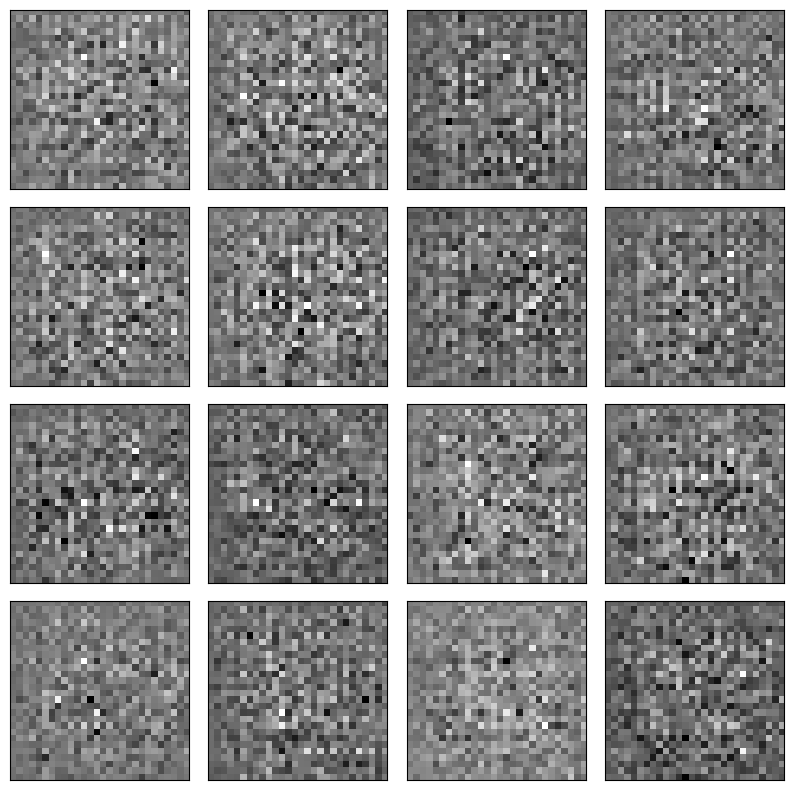




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 233; D_loss=1.1311113834381104; G_loss=1.079528570175171
(16, 28, 28, 1)
EPOCH  1


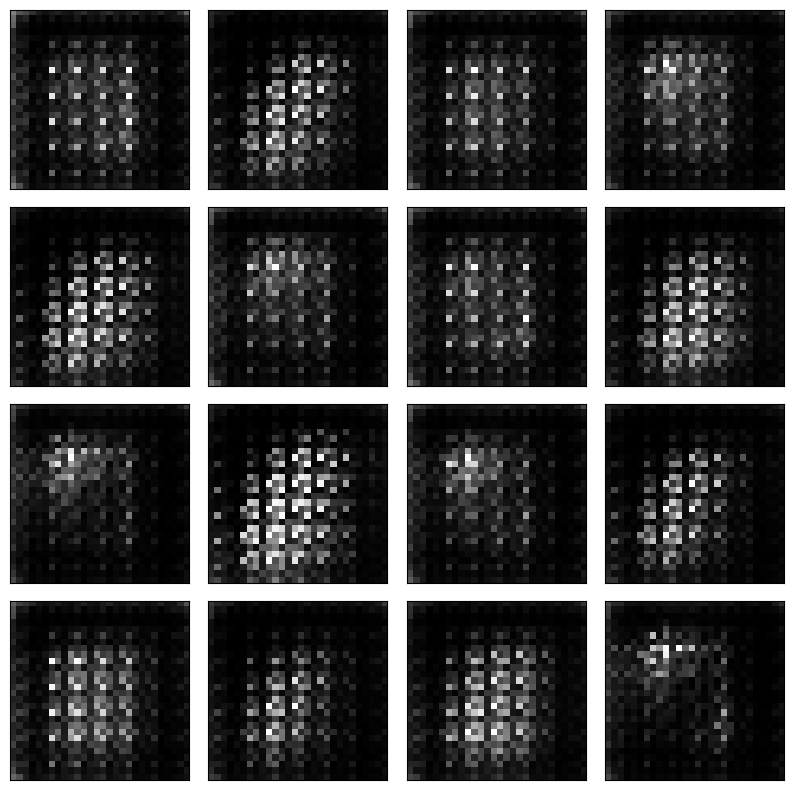




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 233; D_loss=0.46120020747184753; G_loss=2.690598487854004
(16, 28, 28, 1)
EPOCH  2


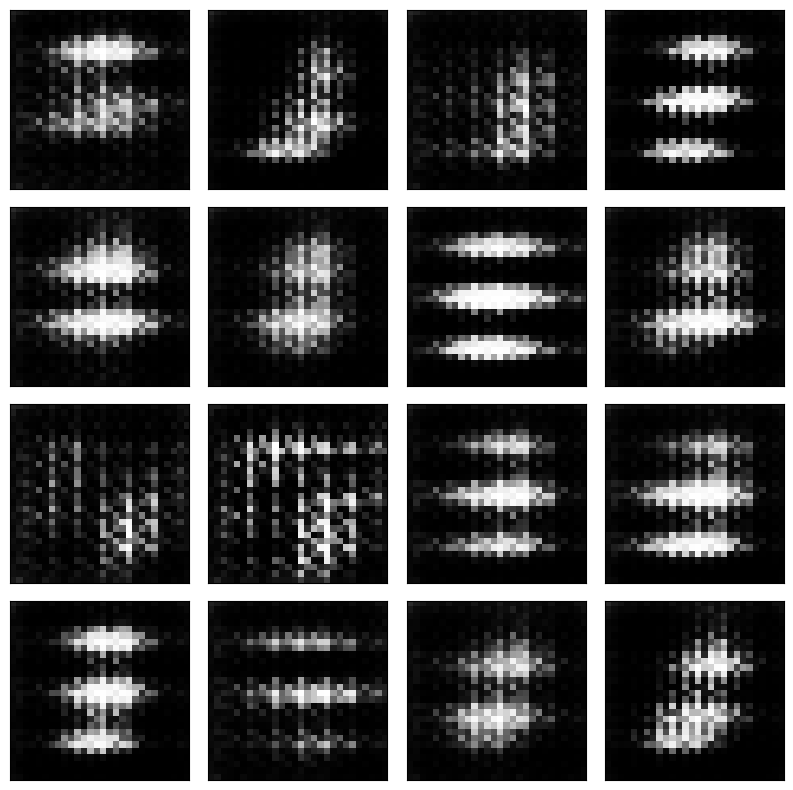




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 233; D_loss=0.47372347116470337; G_loss=2.317821979522705
(16, 28, 28, 1)
EPOCH  3


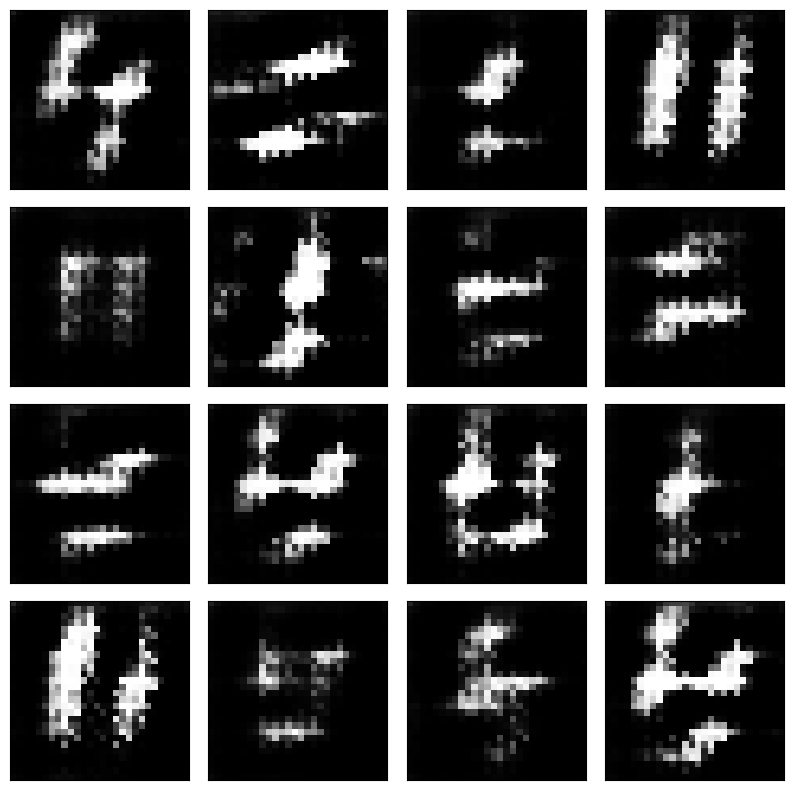




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 233; D_loss=0.25724613666534424; G_loss=2.347296714782715
(16, 28, 28, 1)
EPOCH  4


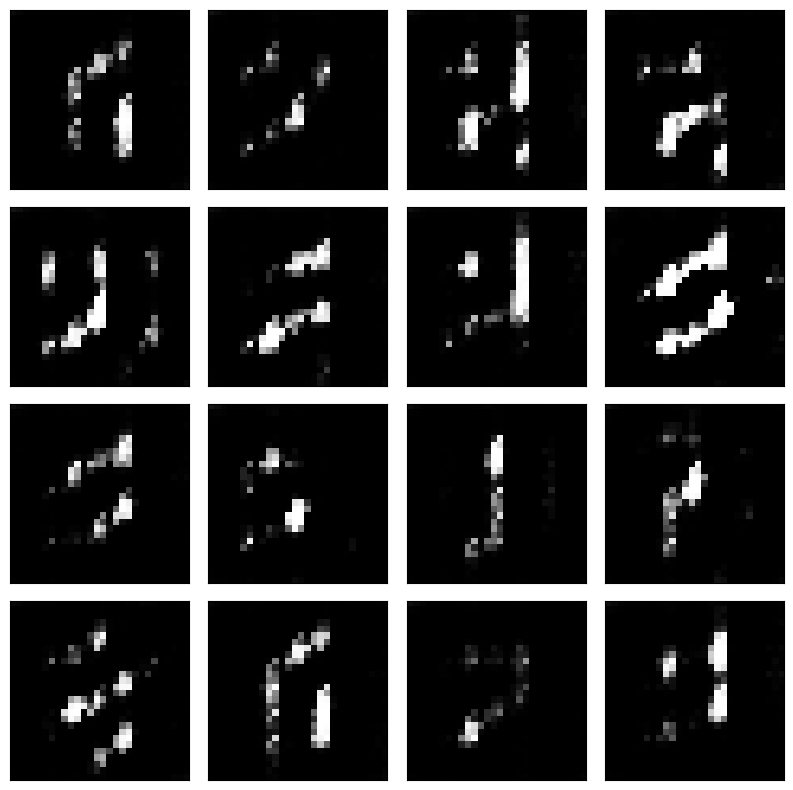




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 233; D_loss=0.79923415184021; G_loss=1.3825780153274536
(16, 28, 28, 1)
EPOCH  5


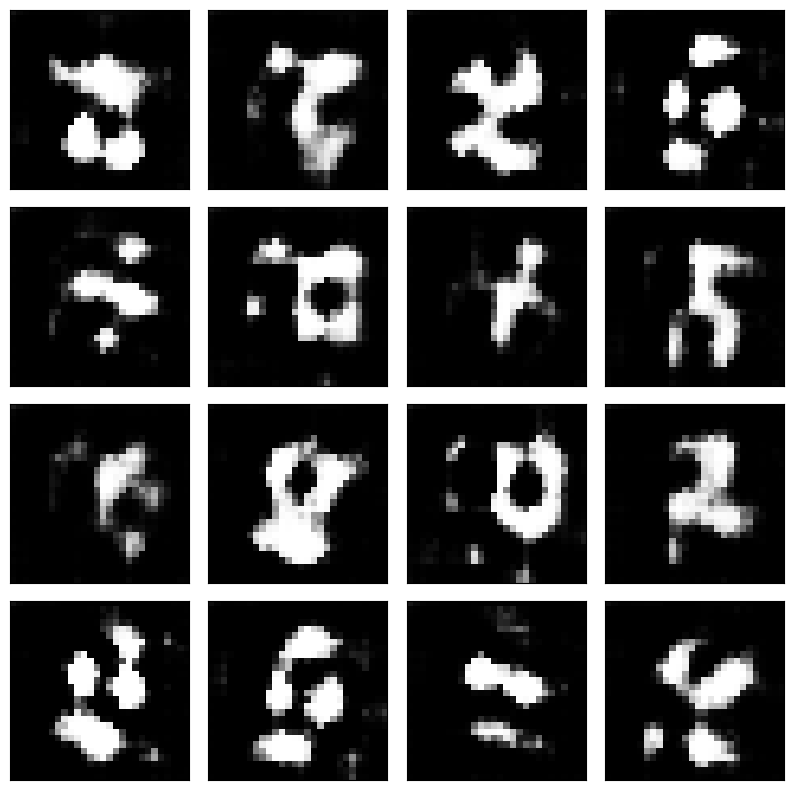




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 233; D_loss=1.072525978088379; G_loss=1.505603313446045
(16, 28, 28, 1)
EPOCH  6


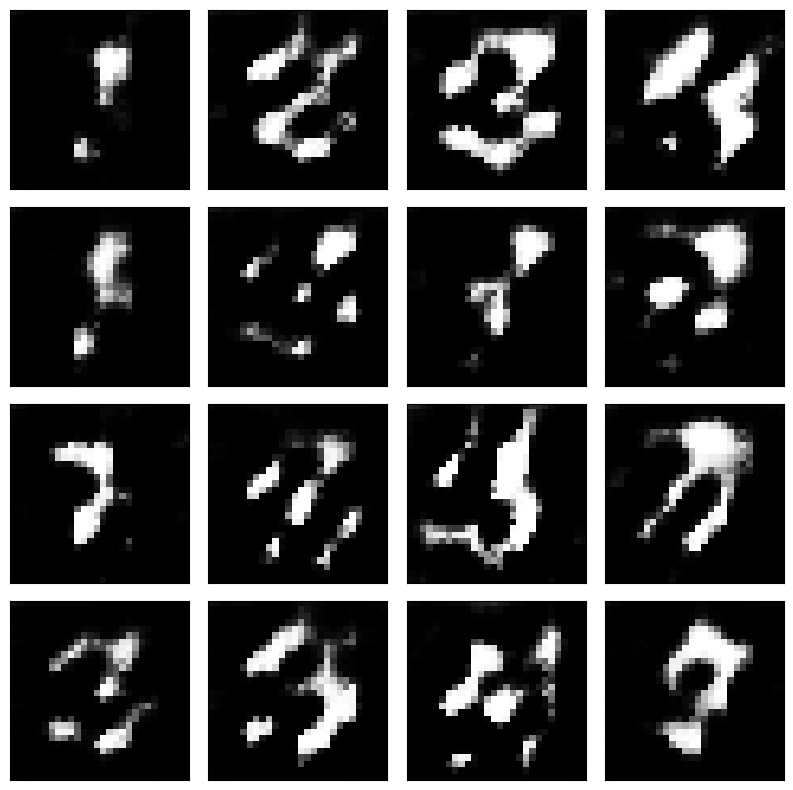




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 233; D_loss=0.7403697967529297; G_loss=1.970834732055664
(16, 28, 28, 1)
EPOCH  7


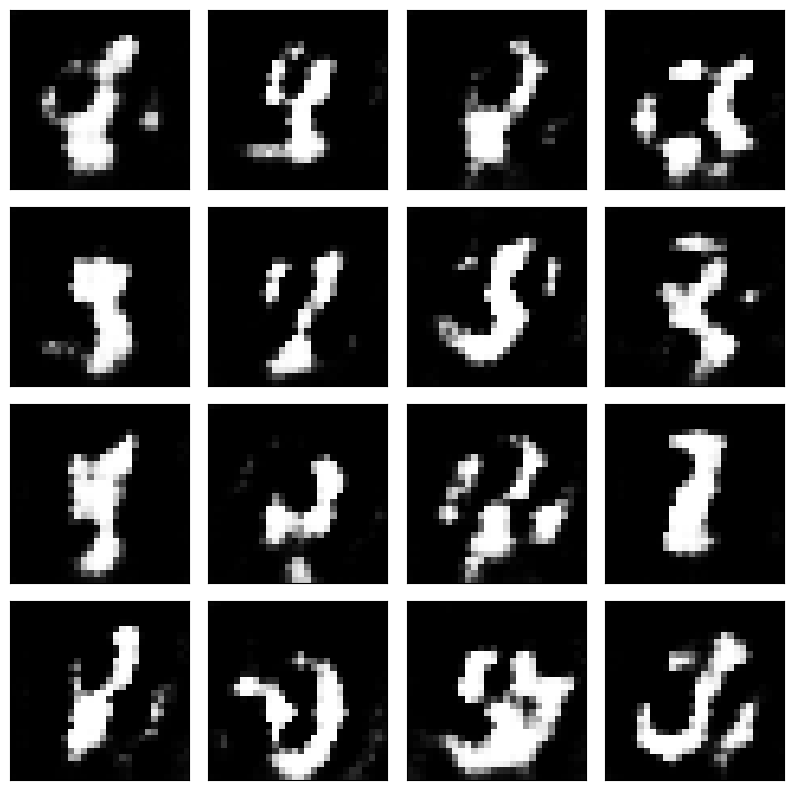




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 233; D_loss=0.5929336547851562; G_loss=2.0614938735961914
(16, 28, 28, 1)
EPOCH  8


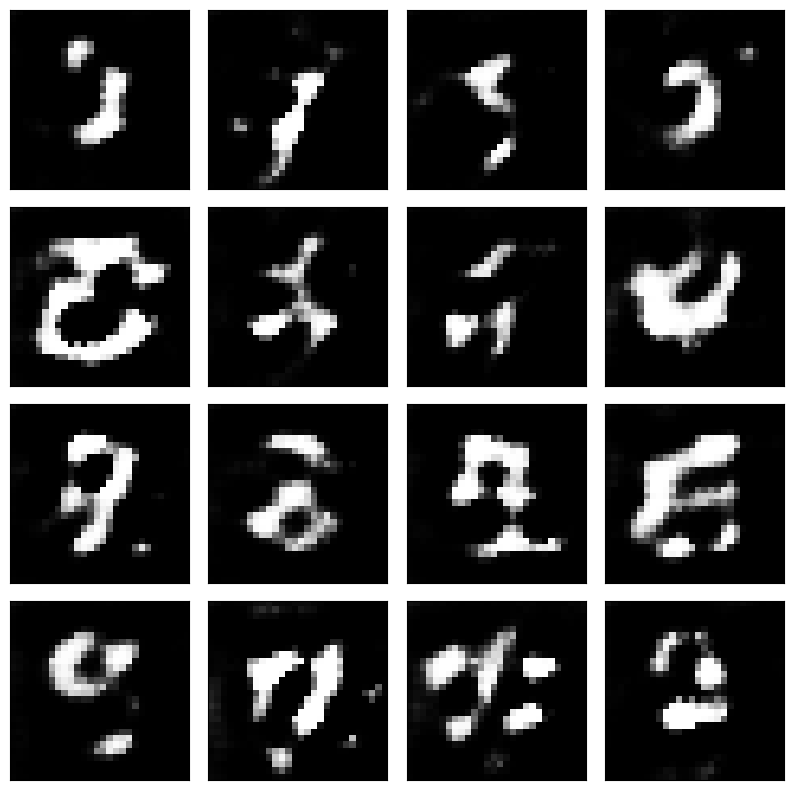




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 233; D_loss=0.9134047627449036; G_loss=1.6464213132858276
(16, 28, 28, 1)
EPOCH  9


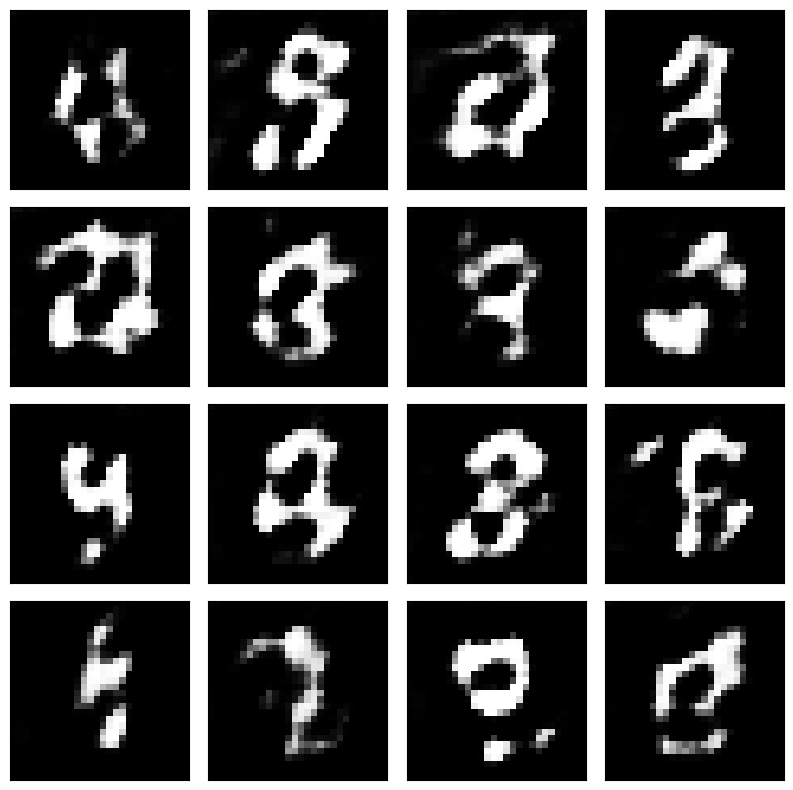




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 233; D_loss=0.8112056255340576; G_loss=1.664924144744873
(16, 28, 28, 1)
EPOCH  10


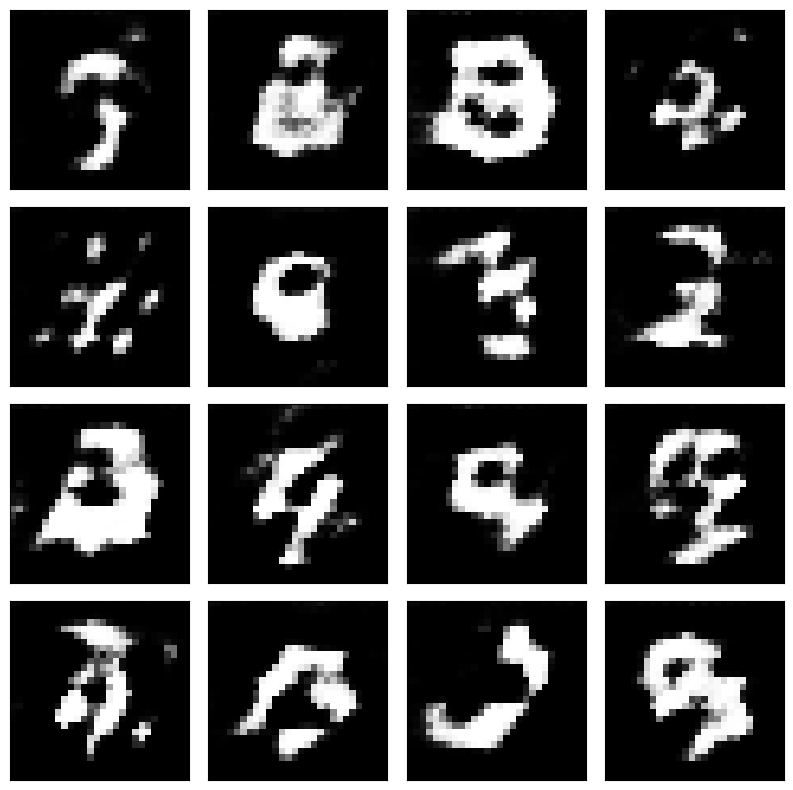




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 233; D_loss=0.8612493872642517; G_loss=1.8107844591140747
(16, 28, 28, 1)
EPOCH  11


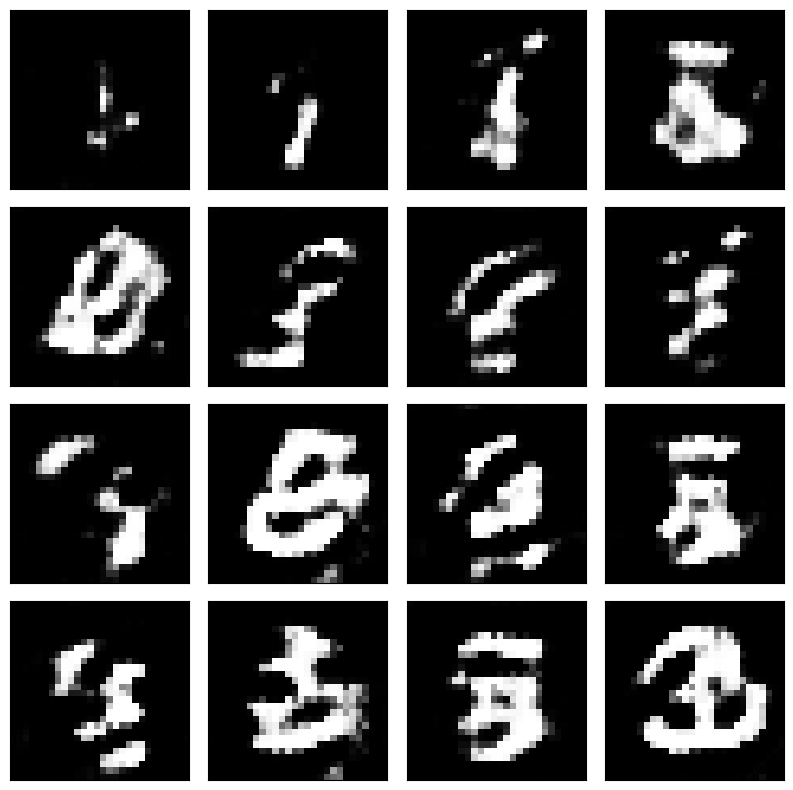




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 233; D_loss=0.7290841341018677; G_loss=2.048205852508545
(16, 28, 28, 1)
EPOCH  12


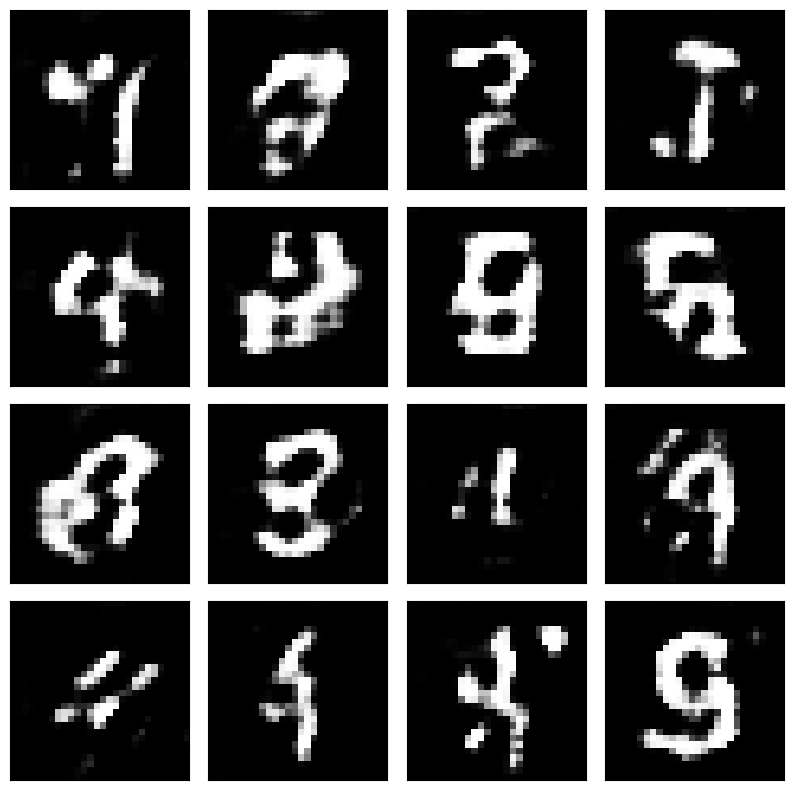




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 233; D_loss=0.9865800738334656; G_loss=1.5538299083709717
(16, 28, 28, 1)
EPOCH  13


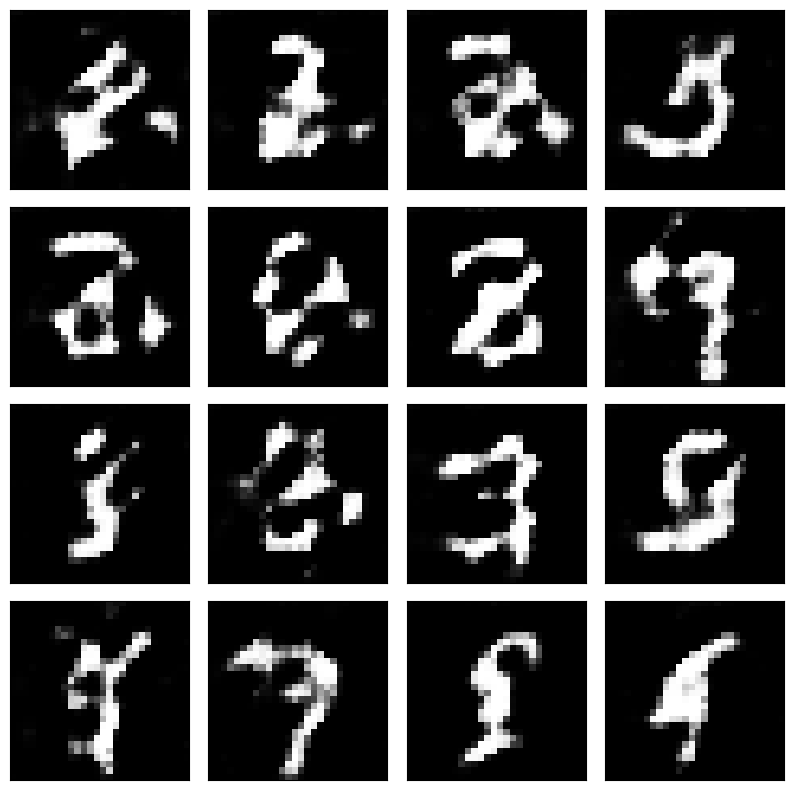




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 233; D_loss=0.7671349048614502; G_loss=1.9226691722869873
(16, 28, 28, 1)
EPOCH  14


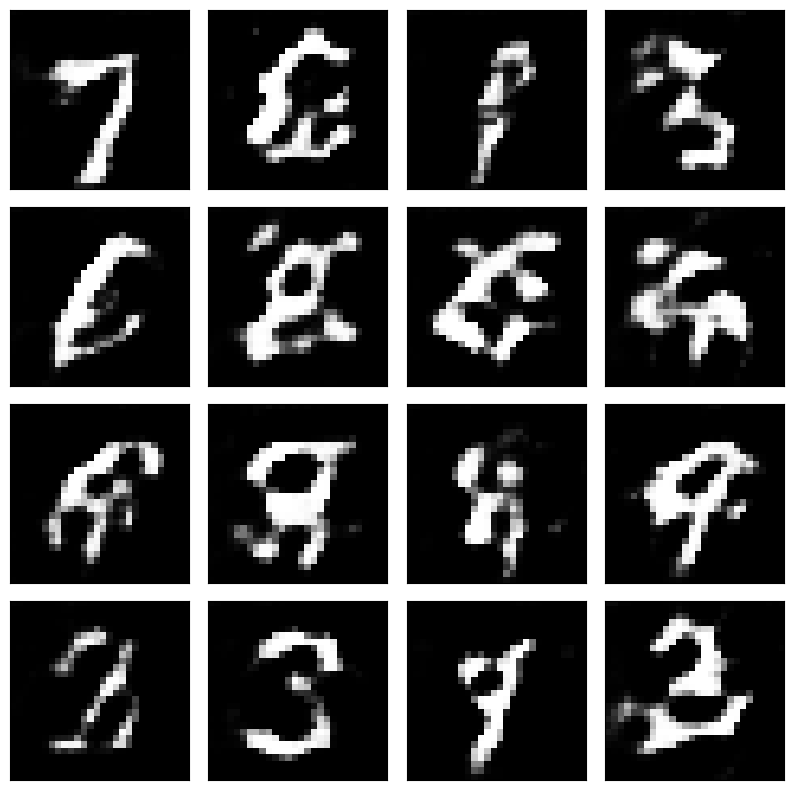




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 233; D_loss=0.7074626684188843; G_loss=1.810025930404663
(16, 28, 28, 1)
EPOCH  15


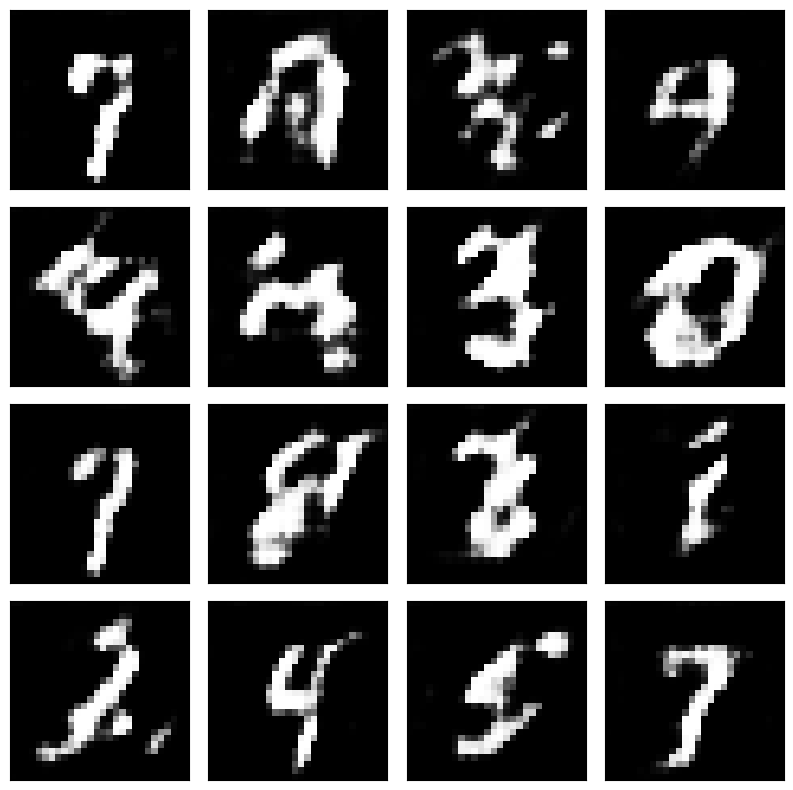




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 233; D_loss=0.89494389295578; G_loss=1.4705079793930054
(16, 28, 28, 1)
EPOCH  16


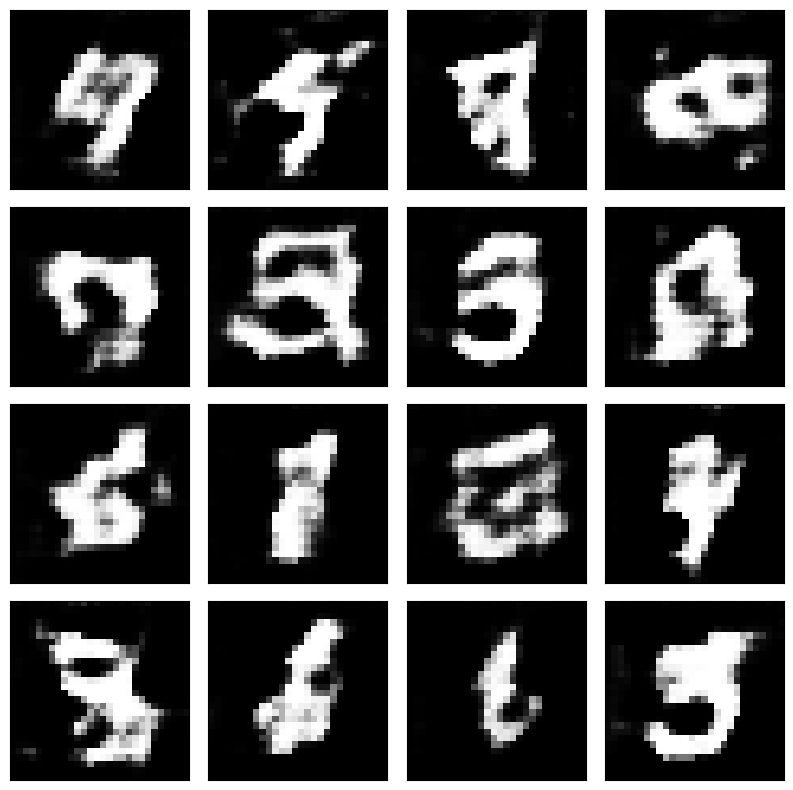




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 233; D_loss=0.9486101865768433; G_loss=1.6404422521591187
(16, 28, 28, 1)
EPOCH  17


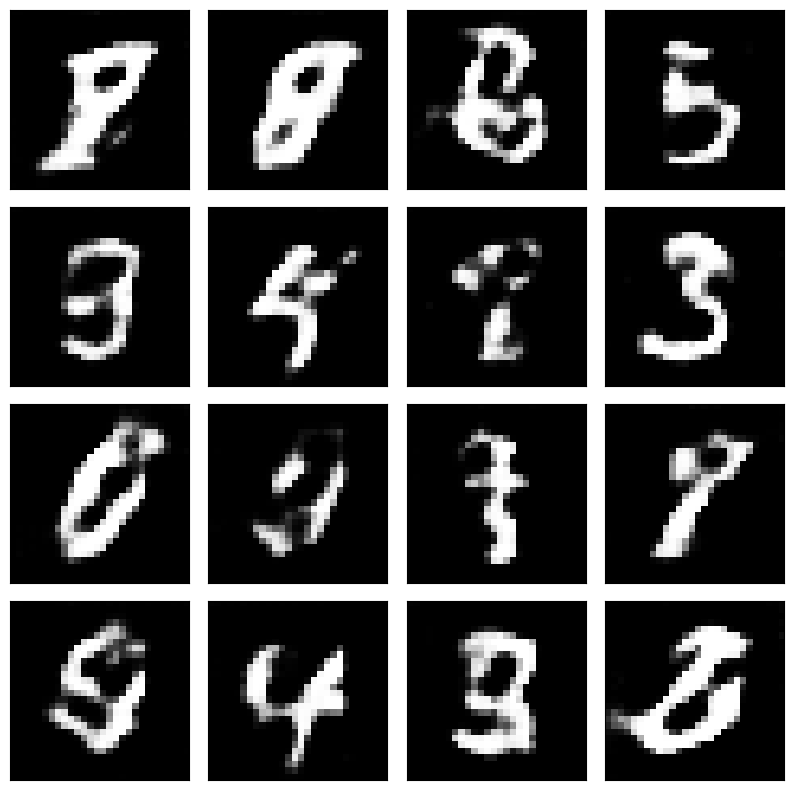




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 233; D_loss=0.861502468585968; G_loss=1.7360554933547974
(16, 28, 28, 1)
EPOCH  18


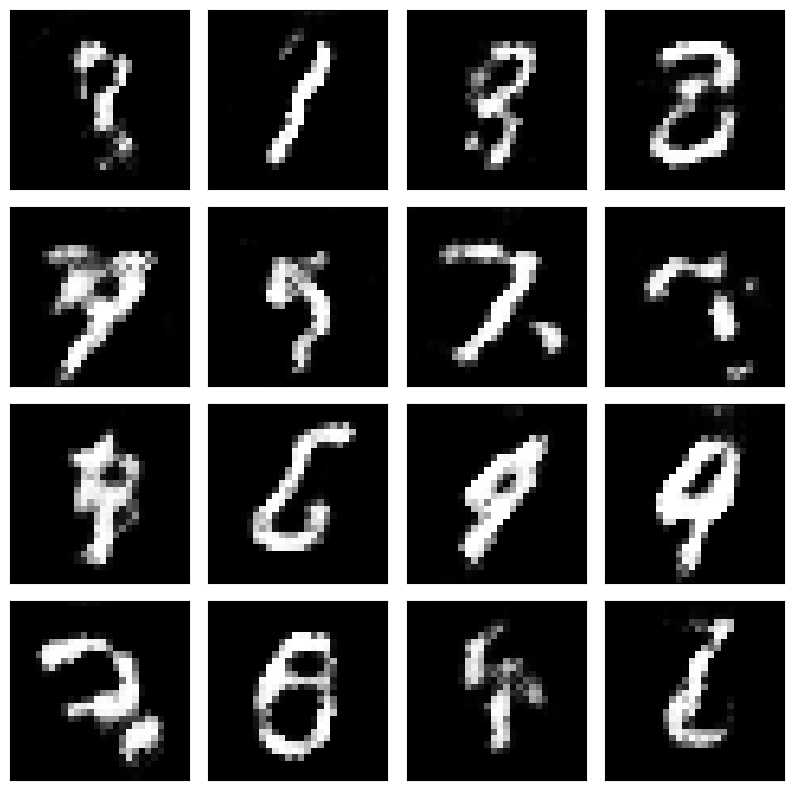




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 233; D_loss=0.6544276475906372; G_loss=1.8443069458007812
(16, 28, 28, 1)
EPOCH  19


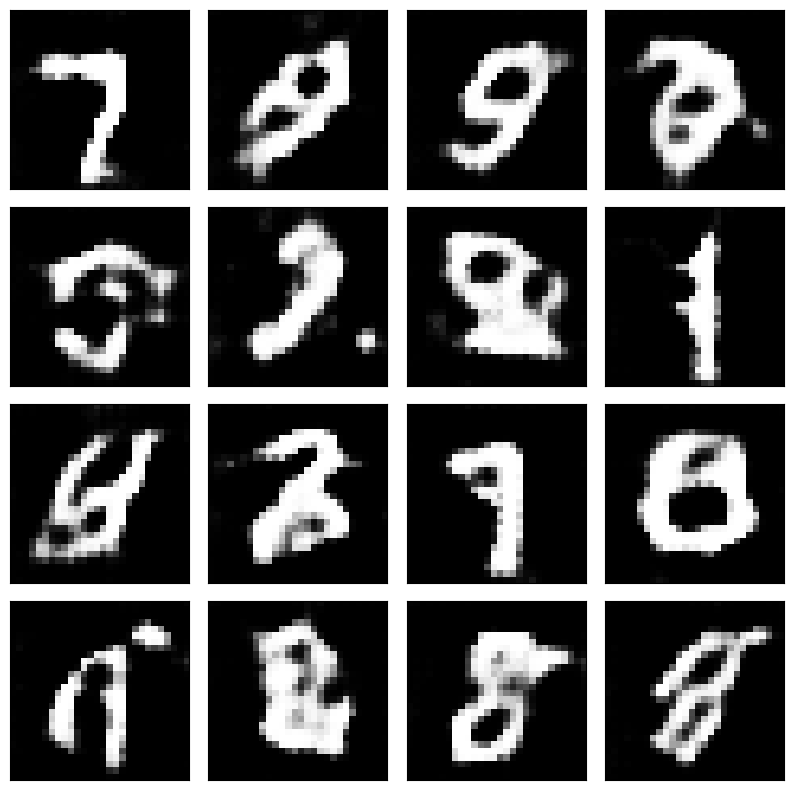




!: Checkpoint has been saved in  /content/drive/MyDrive/Colab Notebooks/train_checkpoints
Epoch 233; D_loss=1.0338095426559448; G_loss=1.5095821619033813


In [50]:






#TRAINING LOOP

for n_epoch in range(EPOCHS):

    generated_examples = generator(tf.random.normal((16, noise_dim)), training=False)
    print(generated_examples.shape)
    print("EPOCH ", n_epoch)
    visualize_generated_images(generated_examples)

    for ith_batch in range(n_batches):

        batch = train_images[ith_batch * 256: (ith_batch + 1) * 256]
        noise = tf.random.normal((BATCH_SIZE, noise_dim))

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

            generated_images = generator(noise, training=True)

            real_output = discriminator(batch, training=True)
            fake_output = discriminator(generated_images, training=True)

            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

        #Compute grads
        G_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
        D_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        #update params
        G_optimizer.apply_gradients(zip(G_grads, generator.trainable_variables))
        D_optimizer.apply_gradients(zip(D_grads, discriminator.trainable_variables))



    manager.save(checkpoint_number=n_epoch)
    print("\n\n")
    print("!: Checkpoint has been saved in ", checkpoint_dir)
    print(f"Epoch {ith_batch}; D_loss={disc_loss}; G_loss={gen_loss}")


In [51]:
generator.save(base_dir + "generator_trained")
discriminator.save(base_dir + "discriminator_trained")

In [ ]:
noise = tf.random.normal((1, 100))

image = np.array(generator(noise)).reshape(28, 28)

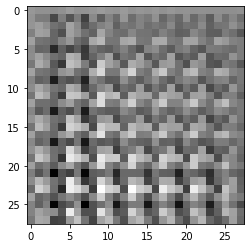

In [ ]:
plt.imshow(image, cmap="gray")
